
## ====== Install specific libraries version to avoid dependency conflicts====

In [ ]:
!pip install optuna
!pip install shap==0.46.0
!pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.2/540.2 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: shap
    Found existing installation: shap 0.47.1
    Uninstalling shap-0.47.1:
      Successfully uninstalled shap-0.47.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, Activation, Add, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/df_metabolites_.csv")
# Split features and target
X = df.drop('TNBC_Subtype', axis=1).values
y = df['TNBC_Subtype'].values

# Label encoding and one-hot encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for 1D CNN: (samples, features, 1)
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Input shape
input_shape = X_train.shape[1:]

# Residual block
def residual_block(x, filters, kernel_size, dropout_rate=0.3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Project shortcut if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Build the CNN model
inputs = Input(shape=input_shape)
x = Conv1D(64, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = residual_block(x, 128, 3)
x = residual_block(x, 256, 3)
x = residual_block(x, 512, 3)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 70, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 70, 64)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 70, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 70, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 70, 128)   │     24,704 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 70, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 70, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 70, 128)   │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 70, 128)   │     49,280 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 70, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 70, 128)   │      8,320 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 70, 128)   │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 70, 128)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 70, 256)   │     98,560 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 70, 256)   │      1,024 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 70, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 70, 256)   │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 70, 256)   │    196,864 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 70, 256)   │      1,024 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,318,852 (24.10 MB)

 Trainable params: 6,315,140 (24.09 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.6473 - loss: 0.9254 - val_accuracy: 0.8542 - val_loss: 0.3985
Epoch 2/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8442 - loss: 0.4410 - val_accuracy: 0.8754 - val_loss: 0.3325
Epoch 3/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8613 - loss: 0.3801 - val_accuracy: 0.8799 - val_loss: 0.3306
Epoch 4/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8775 - loss: 0.3462 - val_accuracy: 0.8850 - val_loss: 0.3258
Epoch 5/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8854 - loss: 0.3119 - val_accuracy: 0.8928 - val_loss: 0.3090
Epoch 6/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8898 - loss: 0.2944 - val_accuracy: 0.8887 - val_loss: 0.3030
Epoch 7/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8945 - loss: 0.2857 - val_accuracy: 0.8917 - val_loss: 0.3024
Epoch 8/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9005 - loss: 0.2680 - val_accuracy: 

##===Save Models for Comparabilty and Web App======

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SAVED_MODELS/DEEPLEARNING/FULL_METABOLITES/ResCNN_M.pth')
print("ResCNN model saved successfully!")

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9077 - loss: 0.3799
Test Loss: 0.39286354184150696
Test Accuracy: 0.9054705500602722
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

--- Classification Report ---
              precision    recall  f1-score   support

         BL1       0.92      0.89      0.90      1404
         BL2       0.87      0.92      0.89      1502
         LAR       0.91      0.90      0.91      2211
           M       0.92      0.91      0.91      1939

    accuracy                           0.91      7056
   macro avg       0.90      0.90      0.90      7056
weighted avg       0.91      0.91      0.91      7056



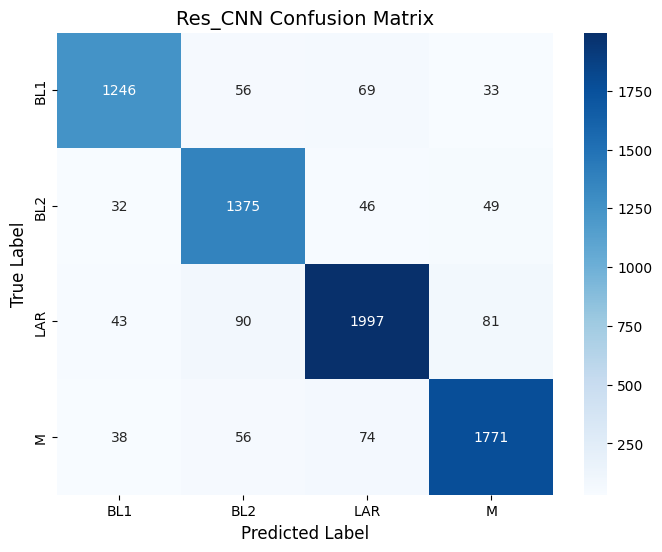

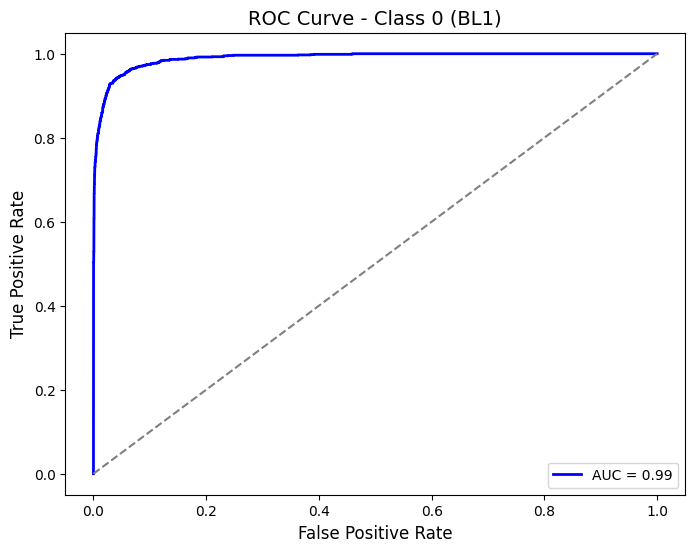

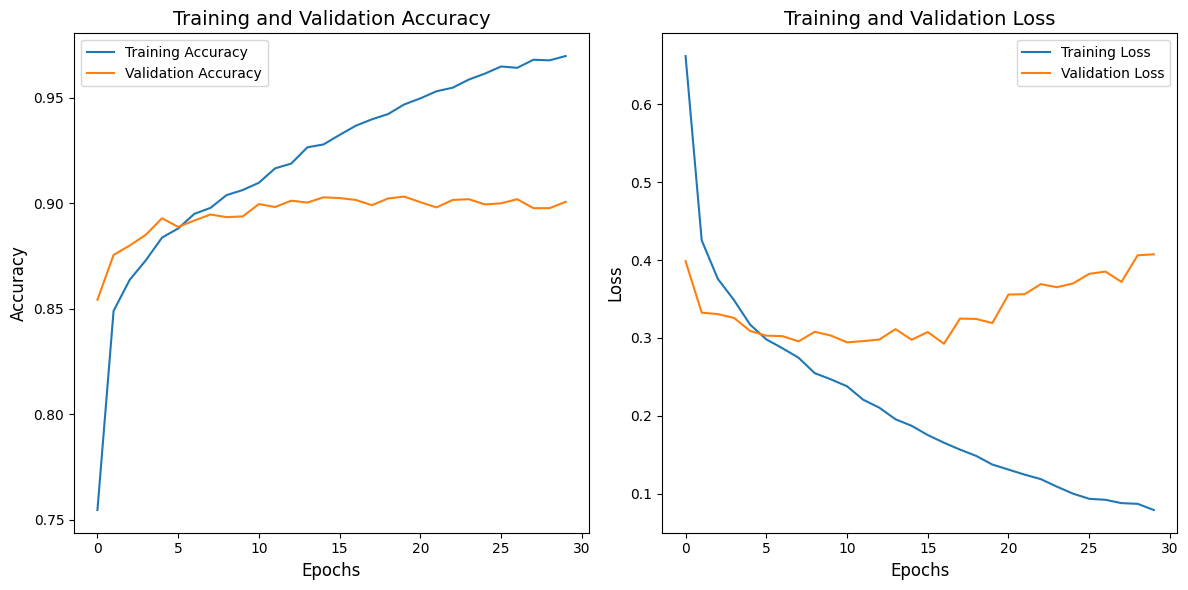


--- Model Metrics Summary ---
Test Loss: 0.3929
Test Accuracy: 0.9055


In [ ]:


# ==================== Metrics ====================
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Classification Report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\n--- Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=['BL1', 'BL2', 'LAR', 'M']))

# ==================== Confusion Matrix ====================
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['BL1', 'BL2', 'LAR', 'M'], yticklabels=['BL1', 'BL2', 'LAR', 'M'])
plt.title('Res_CNN Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# ==================== ROC Curve ====================
fpr, tpr, _ = roc_curve(y_true_labels, y_pred[:, 0], pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve - Class 0 (BL1)', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.show()

# ==================== Learning Curve ====================
# Plot learning curves for accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

# ==================== Metrics Summary ====================
print("\n--- Model Metrics Summary ---")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:
# --- Create a Wrapper for Model Prediction ---
def predict_fn(input_data):
    # Ensure the input is reshaped to the expected shape for the model
    input_data_reshaped = input_data.reshape(input_data.shape[0], input_data.shape[1], 1)  # (batch_size, features, 1)

    # Predict with the model and return as a numpy array (no need for .numpy())
    return model.predict(input_data_reshaped)  # Already a NumPy array

# --- Prepare SHAP Data ---
X_shap = X_test[:500]  # shape: (500, 70) as now there are 70 metabolites

# Remove the last dimension (shape should become (500, 70))
X_shap_reshaped = X_shap.reshape(X_shap.shape[0], X_shap.shape[1])  # Now (500, 70)

# --- Initialize SHAP KernelExplainer ---
# Using shap.kmeans to summarize the background data (reduce size of background dataset)
background_data = shap.kmeans(X_shap_reshaped, 10)  # Using 10 clusters to summarize the background data

# Initialize SHAP KernelExplainer with the prediction function wrapper
explainer = shap.KernelExplainer(predict_fn, background_data)

# --- Compute SHAP values ---
shap_values = explainer.shap_values(X_shap_reshaped, nsamples=100)  # Compute for the first 100 samples

# --- Correcting Feature Names ---
# Extract the feature names from your dataset (assuming 'df' has 70 metabolites)
feature_names = df.drop(columns=["TNBC_Subtype"]).columns.tolist()  # Should now be 70 features



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 18 iterations, i.e. alpha=1.029e-03, with an active set of 18 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 40 iterations, i.e. alpha=2.599e-04, with an active set of 30 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 43 iterations, alpha=2.355e-04, previous alpha=2.316e-04, with 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

### Explanation of SHAP Summary Section:
SHAP Summary Plot: Generates the summary plot for the SHAP values of each class. This plot shows the distribution of SHAP values for each feature, helping visualize which features have the largest impact on the model's predictions.
Top 10 SHAP Summary Plot: Focuses only on the top 10 most important features by SHAP values, providing a clearer understanding of the features that drive predictions the most.
Waterfall Plot: Visualizes the contribution of each feature to the prediction for a specific instance (e.g., instance 0). It shows how much each feature shifted the prediction for that class.

SHAP shape after transpose: (4, 500, 70)


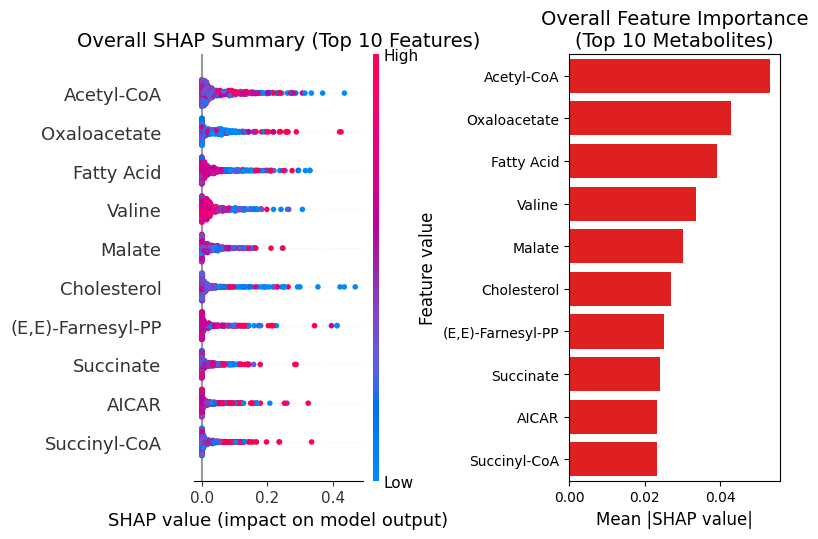

In [ ]:
#--- Fix SHAP Values (assuming shape is (classes, samples, features)) ---
shap_values = np.transpose(shap_values, (2, 0, 1))  # Now shape = (classes, samples, features)
print("SHAP shape after transpose:", shap_values.shape)

# --- Get Unique Subtypes ---
subtype_names = df['TNBC_Subtype'].unique()  # Get unique TNBC subtypes from your dataset
# ==================== Overall SHAP Summary and Feature Importance ====================

# Compute the overall mean absolute SHAP values for global feature importance
shap_vals_all_classes = np.mean(np.abs(shap_values), axis=0)  # shape: (samples, features)
shap_importance_all = np.mean(shap_vals_all_classes, axis=0)

# Get indices for the top 10 overall features
sorted_idx_all = np.argsort(shap_importance_all)[-10:]  # Get top 10 metabolites
top_10_metabolites_all = np.array(feature_names)[sorted_idx_all]
top_10_importance_all = shap_importance_all[sorted_idx_all]

# Sort the Importance in Descending Order
top_10_metabolites_all_sorted = top_10_metabolites_all[::-1]
top_10_importance_all_sorted = top_10_importance_all[::-1]

# --- Create a Figure for Overall SHAP Summary and Feature Importance ---
plt.figure(figsize=(16, 6))  # Adjust the figure size to accommodate both plots side by side

# ==================== Overall SHAP Summary Plot (Left) ====================
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
shap.summary_plot(shap_vals_all_classes, X_shap_reshaped, feature_names=feature_names,
                  show=False, plot_type='dot', max_display=10)
plt.title("Overall SHAP Summary (Top 10 Features)", fontsize=14)

# ==================== Overall Feature Importance Bar Plot (Right) ====================
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
sns.barplot(x=top_10_importance_all_sorted, y=top_10_metabolites_all_sorted, color='red', orient='h')
plt.title('Overall Feature Importance\n(Top 10 Metabolites)', fontsize=14)
plt.xlabel('Mean |SHAP value|', fontsize=12)

# Adjust the layout so that the plots don't overlap
plt.tight_layout()
plt.show()

### SHAP Summary for Each TNBC Subtype
This section generates SHAP summary plots for each TNBC subtype to understand the feature importance across the subtypes. It also includes a plot for the top 10 features based on SHAP values and a waterfall plot to show the contribution of features to individual predictions.


--- SHAP Summary for Subtype: Basal-like 2 (BL2) ---


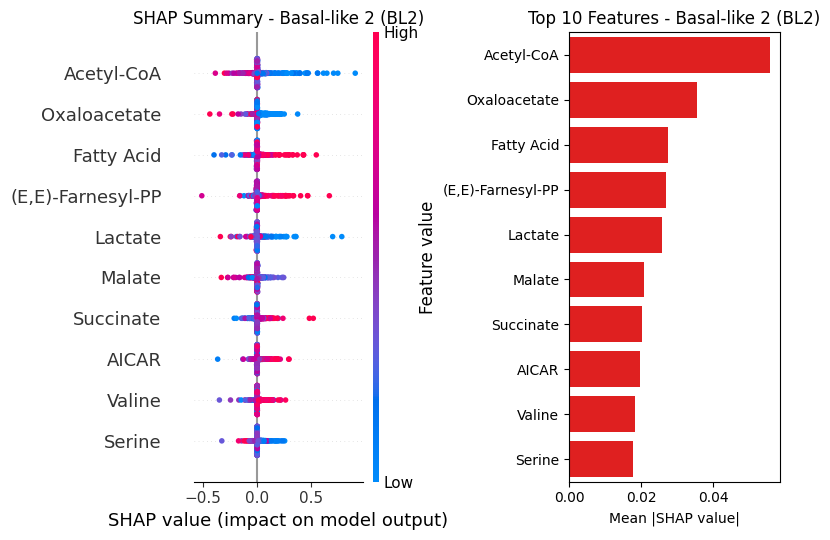


--- SHAP Summary for Subtype: Basal-like 1 (BL1) ---


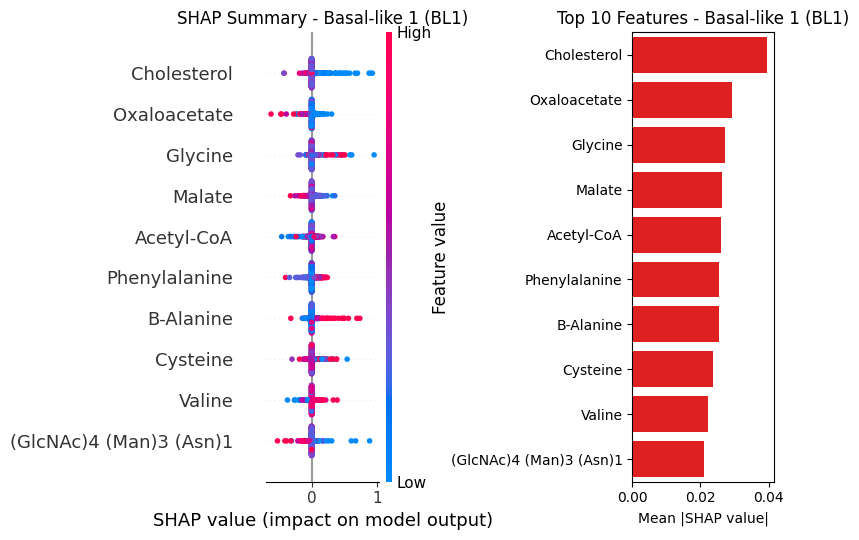


--- SHAP Summary for Subtype: Mesenchymal (M) ---


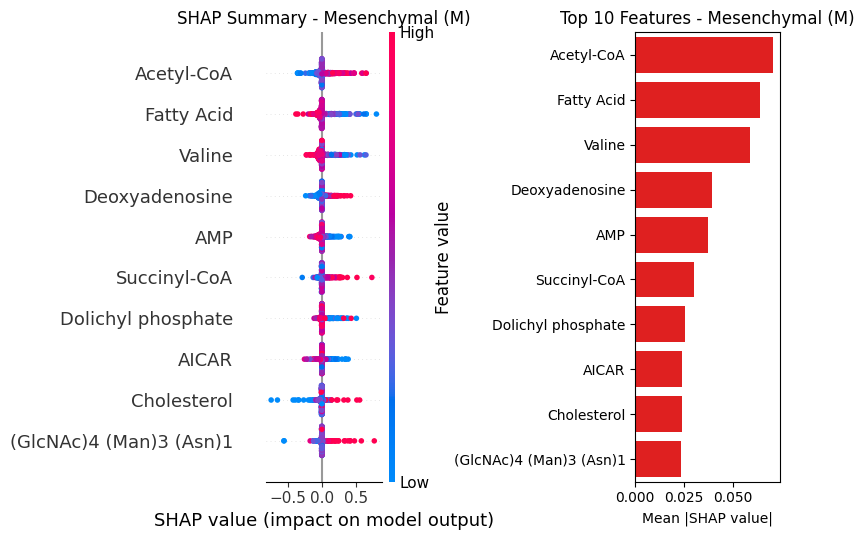


--- SHAP Summary for Subtype: Luminal Androgen Receptor (LAR) ---


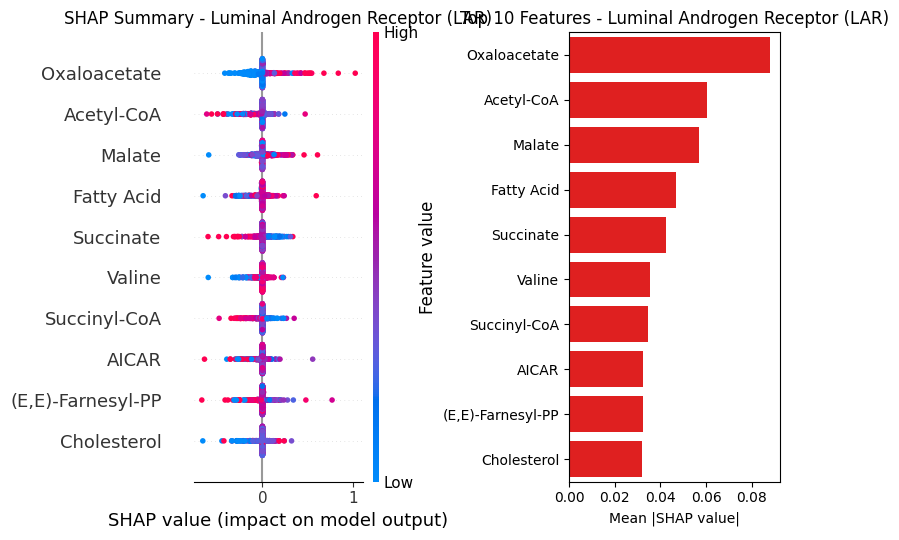

In [ ]:
# ==================== Loop over each Subtype for SHAP Summary and Feature Importance ====================
for i, subtype in enumerate(subtype_names):
    print(f"\n--- SHAP Summary for Subtype: {subtype} ---")

    # Compute the mean absolute SHAP value for ranking the features (for this specific subtype)
    shap_vals_subtype = shap_values[i]  # shape: (samples, features)
    mean_shap_subtype = np.mean(np.abs(shap_vals_subtype), axis=0)

    # Get indices for the top 10 features for this subtype
    top_indices_subtype = np.argsort(mean_shap_subtype)[-10:][::-1]

    # Filter SHAP values and features for top 10
    shap_values_top_subtype = shap_vals_subtype[:, top_indices_subtype]
    X_test_top_subtype = X_shap_reshaped[:, top_indices_subtype]
    top_feature_names_subtype = np.array(feature_names)[top_indices_subtype]

    # ==================== Plot SHAP Summary and Feature Importance for Subtype ====================
    plt.figure(figsize=(14, 6))

    # SHAP Summary Plot for top 10 features (left)
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
    shap.summary_plot(shap_values_top_subtype, X_test_top_subtype, feature_names=top_feature_names_subtype, plot_type='dot', show=False)
    plt.title(f"SHAP Summary - {subtype}")

    # Red bar plot of top 10 features (right)
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
    top_importances_subtype = mean_shap_subtype[top_indices_subtype]
    sns.barplot(x=top_importances_subtype, y=top_feature_names_subtype, color='red')
    plt.title(f"Top 10 Features - {subtype}")
    plt.xlabel("Mean |SHAP value|")

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Assuming 'shap_values' is a (samples, features) matrix of SHAP values
# And 'X_shap_reshaped' is your reshaped test data

# Calculate the mean absolute SHAP value for each feature across all samples
mean_shap_values = np.mean(np.abs(shap_values), axis=0)  # Mean absolute SHAP value per feature
feature_names = df.drop(columns=["TNBC_Subtype"]).columns.tolist()  # Your list of feature names (metabolites)

# Print summary for each feature (metabolite) and its contribution
print("Feature-wise SHAP Value Summary:")
print("="*60)
print("{:<30} {:<15} {:<15} {:<15}".format("Feature", "Mean SHAP Value", "Positive Impact", "Negative Impact"))
print("-"*60)

# Loop through each feature and print its SHAP value summary
for i, feature in enumerate(feature_names):
    # SHAP values for this feature across all samples
    feature_shap_values = shap_values[:, i]

    # Calculate the effect on positive and negative sides
    positive_effect = np.sum(feature_shap_values > 0)  # Count how many times the effect was positive
    negative_effect = np.sum(feature_shap_values < 0)  # Count how many times the effect was negative

    # Calculate mean SHAP value for the feature
    mean_shap_value = np.mean(feature_shap_values)

    # Print the results
    print("{:<30} {:<15.4f} {:<15} {:<15}".format(feature, mean_shap_value, positive_effect, negative_effect))

print("="*60)

# --- Optionally, create a DataFrame to store these values for further analysis ---
shap_summary_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean SHAP Value': mean_shap_values,
    'Positive Impact Count': np.sum(shap_values > 0, axis=0),
    'Negative Impact Count': np.sum(shap_values < 0, axis=0)
})

# Sort the DataFrame based on mean SHAP value for better readability
shap_summary_df = shap_summary_df.sort_values(by='Mean SHAP Value', ascending=False)

# Optionally print the sorted table
print("\n--- SHAP Summary DataFrame ---")
print(shap_summary_df)



Feature-wise SHAP Value Summary:
Feature                        Mean SHAP Value Positive Impact Negative Impact
------------------------------------------------------------
AMP                            -0.0000         59              74             
Pyruvate                       -0.0000         35              49             
Acetyl-CoA                     -0.0000         47              52             
Glutamate                      -0.0000         40              54             
2OG                            -0.0000         30              42             
Oxaloacetate                   -0.0000         46              50             
Glycine                        -0.0000         35              45             
Succinate                      -0.0000         44              47             
UDP-N-acetylglucosamine        -0.0000         32              51             
lysine                         -0.0000         43              54             
Aspartate                      0.0000

ValueError: Per-column arrays must each be 1-dimensional

##======USING UMAP DATAFRAME====

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, Activation, Add, Dropout, Flatten, Dense)
from tensorflow.keras.optimizers import Adam


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MY THESIS/Thesis/metabolites_umap_training_.csv")

# Split features and target
X = df.drop('TNBC_Subtype', axis=1).values
y = df['TNBC_Subtype'].values

# Label encoding and one-hot encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for 1D CNN: (samples, features, 1)
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Input shape
input_shape = X_train.shape[1:]

# Residual block
def residual_block(x, filters, kernel_size, dropout_rate=0.3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # Project shortcut if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Build the CNN model
inputs = Input(shape=input_shape)
x = Conv1D(64, 3, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = residual_block(x, 128, 3)
x = residual_block(x, 256, 3)
x = residual_block(x, 512, 3)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 64)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 10, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 10, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 128)   │     24,704 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 128)   │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 10, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10, 128)   │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 128)   │     49,280 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 10, 128)   │      8,320 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 128)   │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 10, 128)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 10, 256)   │     98,560 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 256)   │      1,024 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 10, 256)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 256)   │          0 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 10, 256)   │    196,864 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10, 256)   │      1,024 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,386,692 (9.10 MB)

 Trainable params: 2,382,980 (9.09 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.8312 - loss: 0.4457 - val_accuracy: 0.9720 - val_loss: 0.0746
Epoch 2/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9538 - loss: 0.1135 - val_accuracy: 0.9761 - val_loss: 0.0565
Epoch 3/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9619 - loss: 0.0938 - val_accuracy: 0.9764 - val_loss: 0.0523
Epoch 4/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9690 - loss: 0.0812 - val_accuracy: 0.9805 - val_loss: 0.0509
Epoch 5/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9701 - loss: 0.0761 - val_accuracy: 0.9828 - val_loss: 0.0393
Epoch 6/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9725 - loss: 0.0703 - val_accuracy: 0.9780 - val_loss: 0.0489
Epoch 7/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9712 - loss: 0.0719 - val_accuracy: 0.9810 - val_loss: 0.0480
Epoch 8/30
353/353 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9716 - loss: 0.0689 - val_accuracy: 

##===Save Models for Comparabilty and Web App======

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SAVED_MODELS/DEEPLEARNING/UMAP/Res_CNN.pth')
print("Res_CNN model saved successfully!")

##========================= Model Evaluation ==========================

221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9857 - loss: 0.0380
Test Loss: 0.035981640219688416
Test Accuracy: 0.9849773049354553
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

--- Classification Report ---
              precision    recall  f1-score   support

         BL1       0.99      0.98      0.98      1404
         BL2       0.98      0.99      0.98      1939
         LAR       0.97      1.00      0.99      1502
           M       0.99      0.98      0.98      2211

    accuracy                           0.98      7056
   macro avg       0.98      0.99      0.99      7056
weighted avg       0.99      0.98      0.98      7056



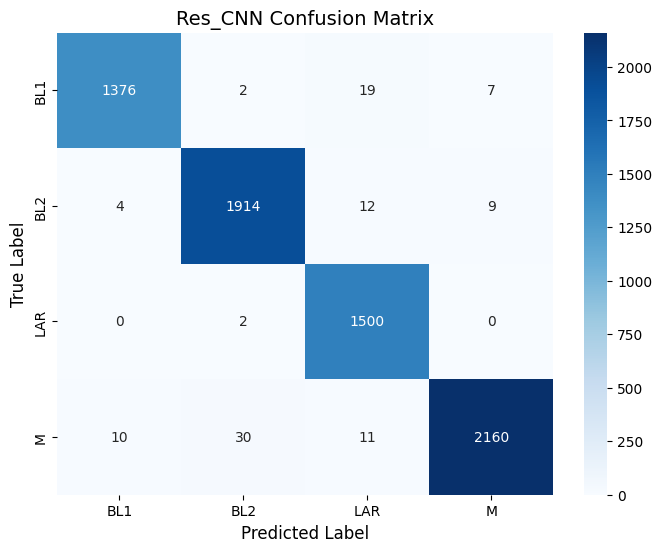

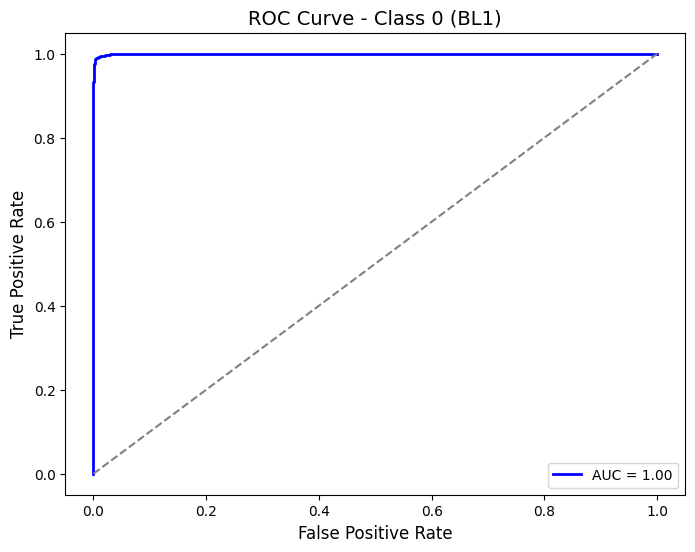

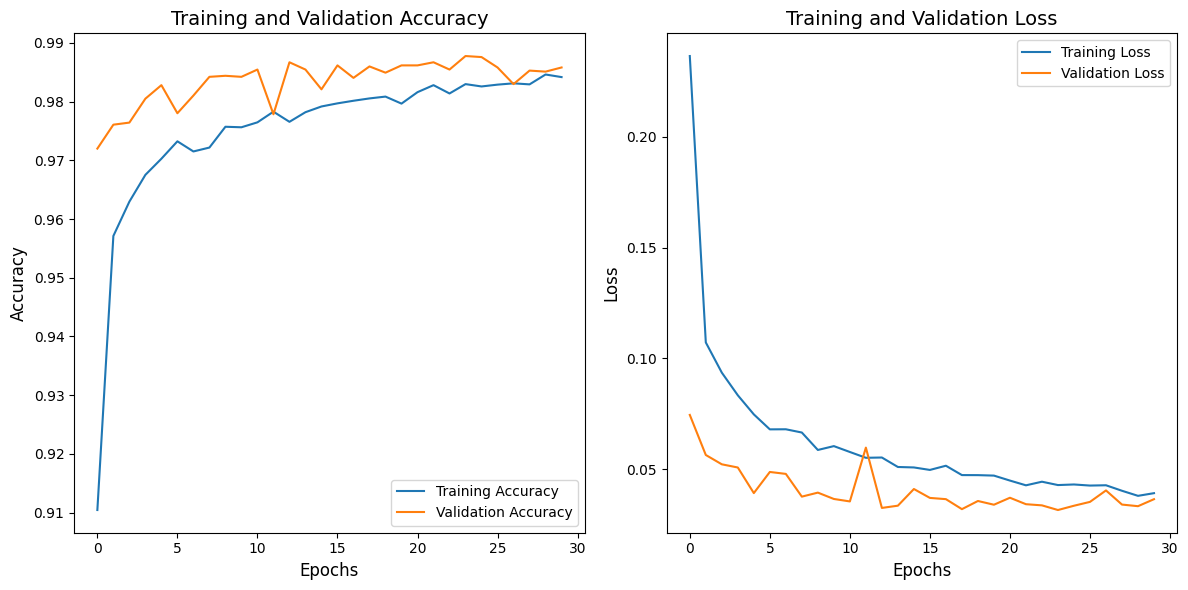


--- Model Metrics Summary ---
Test Loss: 0.0360
Test Accuracy: 0.9850


In [ ]:


# ==================== Metrics ====================
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Classification Report
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\n--- Classification Report ---")
print(classification_report(y_true_labels, y_pred_labels, target_names=['BL1', 'BL2', 'LAR', 'M']))

# ==================== Confusion Matrix ====================
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['BL1', 'BL2', 'LAR', 'M'], yticklabels=['BL1', 'BL2', 'LAR', 'M'])
plt.title('Res_CNN Confusion Matrix', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# ==================== ROC Curve ====================
fpr, tpr, _ = roc_curve(y_true_labels, y_pred[:, 0], pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve - Class 0 (BL1)', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(loc='lower right')
plt.show()

# ==================== Learning Curve ====================
# Plot learning curves for accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

# ==================== Metrics Summary ====================
print("\n--- Model Metrics Summary ---")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
